## Mónica Villasuso López.
### Proyecto Individual - Datascience Bootcamp

## Clasificación de Lunares usando DATA AUGMENTATION
## usando Flow from directory con las imágenes a color

Referencias:  
https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720


In [185]:
# Manejo de archivos y directorios
import os
from os import listdir
from os.path import isfile, join

# Básicas (álgebra, números aleatorios, carga de datos en dataframe, visualizacion)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import shuffle

# Manejo de imágenes
import imageio
import cv2

# Modelos de redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,img_to_array

In [556]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v2/Lunares')


Los datos (303 imágenes) están, organizados y distribuidos en train(70%), valid(16%), test (14%), de la siguiente manera:  
IMÁGENES Lunares Benignos =  161   (112+26+23)  
IMAGENES Lunares Malignos = 142  (98+23+21)  
   
train/   
    Benignos/112  
    Malignos/98  
valid/  
    Benignos/26  
    Malignos/23  
test/Test/ 44  

### PRUEBA DE DATA AUGMENTATION

In [557]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=30, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1./255,
                               zoom_range=0.2,
                               shear_range=0.1,
                               fill_mode='nearest')

In [577]:
TARGET_SIZE= (48,48)
COLOR_MODE = "grayscale"   # "rgb" a color o "grayscale" si se quiere en ByN
SEED = 55
SAVEPATH= "/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v2/Lunares/Img_Aumen"  #Esto si se desea guardar en disco las imágenes que se han ido generando para entrenar el modelo

In [578]:
train_generator = augmenter.flow_from_directory(
    directory=r"./train/",
    target_size= TARGET_SIZE,
    color_mode= COLOR_MODE,      
    batch_size=48,          # numero de imágenes a obtener del generador por cada lote
    class_mode="binary",    # "binary", si son más categorias, sería "categorical"
    shuffle=True,
    seed=SEED
    #,save_to_dir=SAVEPATH, save_prefix= "t_", save_format = "png"      #Si se quieren guardar en disco
)  
valid_generator = augmenter.flow_from_directory(
    directory=r"./valid/",
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,       
    batch_size=48,           # numero de imágenes a obtener del generador por cada lote
    class_mode="binary",    # "binary", si son más categorias, sería "categorical"
    shuffle=True,
    seed=SEED
    #, save_to_dir=SAVEPATH, save_prefix = "v_", save_format = "png"    #Si se quieren guardar en disco
)

# Es importante que el batch_size del conjunto de test sea un divisor EXACTO de la cantidad de imágenes 
# que tenemos para test para que las considere TODAS. En el caso de este valor para los conjuntos de 
# train y validacion, no importa tanto esta condición pues si quedan algunas por fuera se considerarán
# en la siguiente iteración. 

# Pero para el conjunto de test, se deben muestrear las imágenes exactamente una vez, ni menos ni más. Si # es confuso, entonces configurar el valor  en 1 (que quizás un poco más lento)

test_generator = augmenter.flow_from_directory(
    directory=r"./test/",
    target_size=TARGET_SIZE,
    color_mode= COLOR_MODE,       
    batch_size=1,           # nro de imágenes a obtener del generador por lote (4 divisor EXACTO de 44)
    class_mode= None,    # para retornar solo la imagen"
    shuffle=False)      #  pues es necesario obtener las imágenes en orden. De esta manera al predecir la salida se hará match con el id o nombre de archivo.


Found 210 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 45 images belonging to 1 classes.


### MODELO 

EL MEJOR accuracy se alcanzó con la siguientes características:  

Settings:  
Random seed = 
%Train = 
----------  
Función de activación --> RELU   (en todas las capas)  
Optimizador --> Adam  
----------  
Una CNN con:  
    - 1 capa convolutiva con 8 neuronas  
    - 1 capa convolutiva con 16 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 capa convolutiva con 32 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25  
    - 1 Flatten  
    - 1 dense con 32 neuronas  
    - 1 dense con 64 neuronas  
    - 1 dense con 2 (Softmax --> salida)


In [579]:
tf.config.run_functions_eagerly(True)

INPUT_SHAPE = (48,48,1)       # Depende de TARGET_SIZE y COLOR_MODE

model2 = keras.models.Sequential()

# First conv-pool layers - set 1
model2.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), 
activation="relu", padding="valid", input_shape=INPUT_SHAPE))
model2.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model2.add(keras.layers.Dropout(rate=0.25))

# Flatten layer
model2.add(keras.layers.Flatten())

# Dense layers
model2.add(keras.layers.Dense(units=32, activation="relu"))
model2.add(keras.layers.Dense(units=64, activation="relu"))
# Output layer
model2.add(keras.layers.Dense(units=2, activation="softmax"))
model2.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 46, 46, 8)         80        
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 44, 44, 16)        1168      
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 22, 22, 16)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 10, 10, 32)      

In [580]:
# Compilar el modelo
# Distintos valores probados para el optimizador (*los mejores) : (*adam, *RMSprop, AdaMax, Adadelta, Adagrad)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [581]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

4 1


In [582]:
history = model2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, 
                    callbacks=callbacks_list)


Epoch 1/50
4/4 [==============================] - 1s 366ms/step - loss: 0.7006 - accuracy: 0.4630 - val_loss: 0.6926 - val_accuracy: 0.5208
Epoch 2/50
4/4 [==============================] - 1s 312ms/step - loss: 0.6921 - accuracy: 0.5370 - val_loss: 0.6906 - val_accuracy: 0.5208
Epoch 3/50
4/4 [==============================] - 1s 318ms/step - loss: 0.6901 - accuracy: 0.5370 - val_loss: 0.6880 - val_accuracy: 0.5208
Epoch 4/50
4/4 [==============================] - 1s 326ms/step - loss: 0.6887 - accuracy: 0.5000 - val_loss: 0.6849 - val_accuracy: 0.5208
Epoch 5/50
4/4 [==============================] - 1s 350ms/step - loss: 0.6793 - accuracy: 0.5617 - val_loss: 0.6769 - val_accuracy: 0.5625
Epoch 6/50
4/4 [==============================] - 2s 475ms/step - loss: 0.6591 - accuracy: 0.6042 - val_loss: 0.6592 - val_accuracy: 0.5833
Epoch 7/50
4/4 [==============================] - 1s 272ms/step - loss: 0.6205 - accuracy: 0.6605 - val_loss: 0.6411 - val_accuracy: 0.6458
Epoch 8/50
4/4 [====

In [583]:

test_loss, test_acc = model2.evaluate(valid_generator,steps=STEP_SIZE_VALID, verbose=2)

1/1 - 0s - loss: 0.5553 - accuracy: 0.7292


[INFO] Generando gráfico...


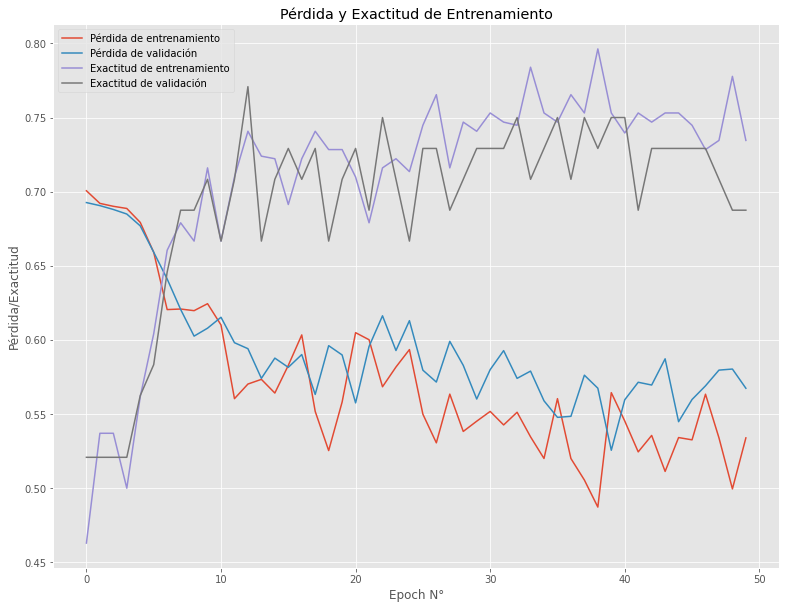

In [584]:
print('[INFO] Generando gráfico...')
plt.figure(figsize=(13,10))
plt.style.use('ggplot')
 
epoch_values = list(range(50))
plt.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
plt.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
plt.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')
 
plt.title('Pérdida y Exactitud de Entrenamiento')
plt.xlabel('Epoch N°')
plt.ylabel('Pérdida/Exactitud')
plt.legend()

### PREDICCIONES CON IMAGENES DE TEST

In [585]:
# You need to reset the test_generator before whenever you call the predict_generator. This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TEST)
test_generator.reset()
pred=model2.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

45
45/45 [==============================] - 1s 21ms/step


In [586]:
#now predicted_class_indices has the predicted labels, but you can’t simply tell what the predictions are
predicted_class_indices=np.argmax(pred,axis=1)

In [587]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [588]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [589]:
results

,Filename,Predictions
0,Test/b101.png,Benigno
1,Test/b106.png,Benigno
2,Test/b11.png,Benigno
3,Test/b136.png,Benigno
4,Test/b146.png,Benigno
5,Test/b151.png,Benigno
6,Test/b156.png,Benigno
7,Test/b16.png,Benigno
8,Test/b21.png,Maligno
9,Test/b26.png,Maligno


====================================================================================================

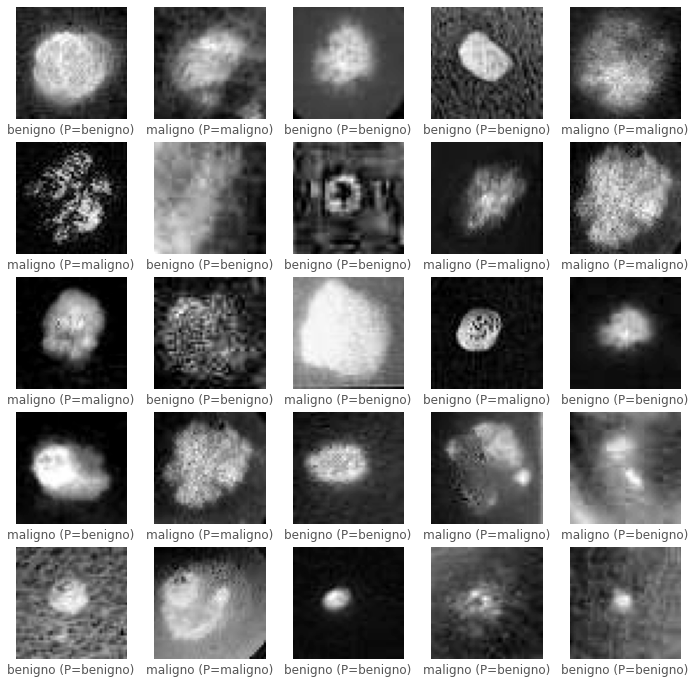

In [49]:
# VER IMAGENES DE TEST (las primeras 25) vs. (P= LO QUE PREDIJO EL MODELO )
# NOTA: (Predictions es un array de 2 posiciones con la probabilidad de que el lunar requiera revisión por especialista o que rsea benigno. Se toma la posicion de la que tenga mayor probabilidad )
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    pred_modelo = np.where(max(predictions[i])==predictions[i])[0][0]
    plt.xlabel(class_names[test_labels[i]] + " (P=" +class_names[pred_modelo] + ")")
plt.show()

### GUARDAR EL MODELO

In [432]:
os.chdir("/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v2/Lunares/modelos")

In [433]:
# Forma PRO de guardar los modelos  (en la carpeta modelos). Guarda el modelo y los pesos por separado. EL primer valor del nombre del archivo del modelo (test_acc)es el % de accuracy que alcanzó con el conjunto de test
import pickle
import json
import time
moment=time.localtime()
name='Model_{}_{}-{}-{}'.format(round(test_acc,5),moment[2],moment[3],moment[4])
model2.save(name)
model_json = model2.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)
model2.save_weights(name+'.h5')

INFO:tensorflow:Assets written to: Model_0.72917_16-15-0/assets


### CARGAR UN MODELO GUARDADO

In [131]:
from tensorflow.keras.models import model_from_json

In [129]:
model_name = '../modelos/Model_0.78261_16-17-21.json'
model_weigths = '../modelos/Model_0.78261_16-17-21.h5'

In [132]:
with open(model_name,'r') as f:
    model_json = json.load(f)
model3 = model_from_json(model_json)
model3.load_weights(model_weigths)

In [133]:
model3

### PRUEBA CON EL MODELO GUARDADO Y CARGADO

### Modificarlo para tratar la imagen que queremos predecir

In [ ]:
model.fit (X,y)
y_pred = model.predict(X)
print(model,  " Score Test:", model.score(X,y)*100,"%", " RMSE:" , mean_squared_error(y, y_pred,squared=False))